In [1]:
import yaml
with open ("/Users/zoe/Documents/Bank-account-fraud/params.yaml") as p:
    params = yaml.safe_load(p)
params

{'data_location': '/Users/zoe/Documents/Bank-account-fraud/data',
 'output_location': '/Users/zoe/Documents/Bank-account-fraud/output'}

In [28]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
import warnings as wr
wr.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [7]:
X_train = pd.read_csv(f"{params['data_location']}/x_train_data.csv", index_col=0)
y_train = pd.read_csv(f"{params['data_location']}/y_train_data.csv", index_col=0)
X_test = pd.read_csv(f"{params['data_location']}/x_test_data.csv", index_col=0)
y_test = pd.read_csv(f"{params['data_location']}/y_test_data.csv", index_col=0)

X_train_smote = pd.read_csv(f"{params['data_location']}/x_train_data_smote.csv", index_col=0)
y_train_smote = pd.read_csv(f"{params['data_location']}/y_train_data_smote.csv", index_col=0)

In [4]:
import xgboost as xgb
from xgboost import XGBClassifier

# Baseline model

Assumptions:
1. imbalaned dataset with low percentage of positive cases, so we use AUC as the measuring metrics
2. assume it's more costly to have higher FN(misclassified fraud cases as not fraud) than higher FP (false alarm for not fraud as fraud). So we aim for a higher recall 

### use xgb.cv to provide a baseline model eval

#### data adjusted with smote no.1

In [183]:
dtrain_smote = xgb.DMatrix(X_train_smote, label=y_train_smote)

In [184]:
# Specify cross-validation parameters
num_boost_round = 1000
n_folds = 10
early_stopping_rounds = 5
model = XGBClassifier()

smote_default_cv_result = xgb.cv(
    params=parameters,
    dtrain=dtrain_smote,
    num_boost_round=num_boost_round,
    nfold=n_folds,
    metrics='auc',
    early_stopping_rounds=early_stopping_rounds,
    seed=42,
    verbose_eval=True,
)

[0]	train-auc:0.95763+0.00009	test-auc:0.95761+0.00087
[1]	train-auc:0.97290+0.00016	test-auc:0.97287+0.00063
[2]	train-auc:0.97615+0.00027	test-auc:0.97616+0.00067
[3]	train-auc:0.98019+0.00016	test-auc:0.98014+0.00039
[4]	train-auc:0.98194+0.00019	test-auc:0.98191+0.00043
[5]	train-auc:0.98377+0.00047	test-auc:0.98371+0.00079
[6]	train-auc:0.98490+0.00062	test-auc:0.98482+0.00086
[7]	train-auc:0.98713+0.00060	test-auc:0.98707+0.00066
[8]	train-auc:0.98904+0.00073	test-auc:0.98899+0.00089
[9]	train-auc:0.99010+0.00041	test-auc:0.99005+0.00048
[10]	train-auc:0.99106+0.00028	test-auc:0.99100+0.00038
[11]	train-auc:0.99161+0.00024	test-auc:0.99153+0.00029
[12]	train-auc:0.99205+0.00022	test-auc:0.99195+0.00026
[13]	train-auc:0.99245+0.00020	test-auc:0.99234+0.00024
[14]	train-auc:0.99279+0.00022	test-auc:0.99269+0.00027
[15]	train-auc:0.99307+0.00018	test-auc:0.99296+0.00025
[16]	train-auc:0.99327+0.00019	test-auc:0.99316+0.00028
[17]	train-auc:0.99344+0.00018	test-auc:0.99332+0.00027
[1

In [185]:
optimal_num_rounds = len(smote_default_cv_result)
print(f"Optimal number of boosting rounds (estimators): {optimal_num_rounds}")

best_auc = smote_default_cv_result['test-auc-mean'].max()
print(f"Best ROC AUC from CV: {best_auc:.4f}")

Optimal number of boosting rounds (estimators): 309
Best ROC AUC from CV: 0.9961


In [171]:
model.n_estimators = optimal_num_rounds

# Train and make predicions with model
model.fit(X_train_smote, y_train_smote)
preds = model.predict_proba(X_test)[:, 1]
baseline_auc = roc_auc_score(y_test, preds)
pred_bool = (preds >= 0.5).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, pred_bool).ravel()
cm = confusion_matrix(y_test, pred_bool)
fpr, tpr, thresholds = roc_curve(y_test, preds)

print(f"Recall (TPR): {tp / (tp + fn):.4f}")
print(f"False Positive Rate (FPR): {fp / (fp + tn):.4f}")

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))

Recall (TPR): 0.0725
False Positive Rate (FPR): 0.0017
The baseline model scores 0.88016 ROC AUC on the test set.


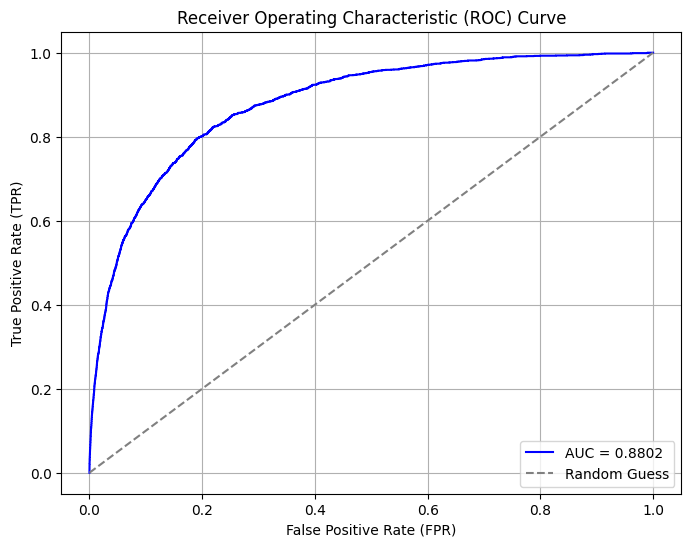

In [172]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {baseline_auc:.4f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

#### data adjusted with smote no.2

In [22]:
dtrain_smote = xgb.DMatrix(X_train_smote, label=y_train_smote)

In [24]:
# Specify cross-validation parameters
num_boost_round = 1000
n_folds = 10
early_stopping_rounds = 5
model = XGBClassifier()

smote_default_cv_result = xgb.cv(
    params=default_params,
    dtrain=dtrain_smote,
    num_boost_round=num_boost_round,
    nfold=n_folds,
    metrics='auc',
    early_stopping_rounds=early_stopping_rounds,
    seed=42,
    verbose_eval=True,
)

[0]	train-auc:0.95873+0.00096	test-auc:0.95858+0.00141
[1]	train-auc:0.96709+0.00014	test-auc:0.96695+0.00048
[2]	train-auc:0.97342+0.00027	test-auc:0.97334+0.00060
[3]	train-auc:0.97617+0.00044	test-auc:0.97608+0.00068
[4]	train-auc:0.97853+0.00033	test-auc:0.97843+0.00047
[5]	train-auc:0.98032+0.00038	test-auc:0.98020+0.00042
[6]	train-auc:0.98203+0.00051	test-auc:0.98189+0.00047
[7]	train-auc:0.98414+0.00038	test-auc:0.98400+0.00049
[8]	train-auc:0.98618+0.00069	test-auc:0.98607+0.00085
[9]	train-auc:0.98870+0.00100	test-auc:0.98858+0.00099
[10]	train-auc:0.99016+0.00071	test-auc:0.99002+0.00061
[11]	train-auc:0.99123+0.00067	test-auc:0.99110+0.00047
[12]	train-auc:0.99220+0.00038	test-auc:0.99207+0.00021
[13]	train-auc:0.99269+0.00041	test-auc:0.99255+0.00031
[14]	train-auc:0.99321+0.00032	test-auc:0.99305+0.00024
[15]	train-auc:0.99365+0.00029	test-auc:0.99349+0.00026
[16]	train-auc:0.99408+0.00025	test-auc:0.99392+0.00031
[17]	train-auc:0.99438+0.00024	test-auc:0.99422+0.00032
[1

In [25]:
optimal_num_rounds = len(smote_default_cv_result)
print(f"Optimal number of boosting rounds (estimators): {optimal_num_rounds}")

best_auc = smote_default_cv_result['test-auc-mean'].max()
print(f"Best ROC AUC from CV: {best_auc:.4f}")

Optimal number of boosting rounds (estimators): 185
Best ROC AUC from CV: 0.9976


In [32]:

from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
model.n_estimators = optimal_num_rounds

# Train and make predicions with model
model.fit(X_train_smote, y_train_smote)
preds = model.predict_proba(X_test)[:, 1]
baseline_auc = roc_auc_score(y_test, preds)
pred_bool = (preds >= 0.5).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, pred_bool).ravel()
cm = confusion_matrix(y_test, pred_bool)
fpr, tpr, thresholds = roc_curve(y_test, preds)

print(f"Recall (TPR): {tp / (tp + fn):.4f}")
print(f"False Positive Rate (FPR): {fp / (fp + tn):.4f}")

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))

Recall (TPR): 0.0996
False Positive Rate (FPR): 0.0024
The baseline model scores 0.88154 ROC AUC on the test set.


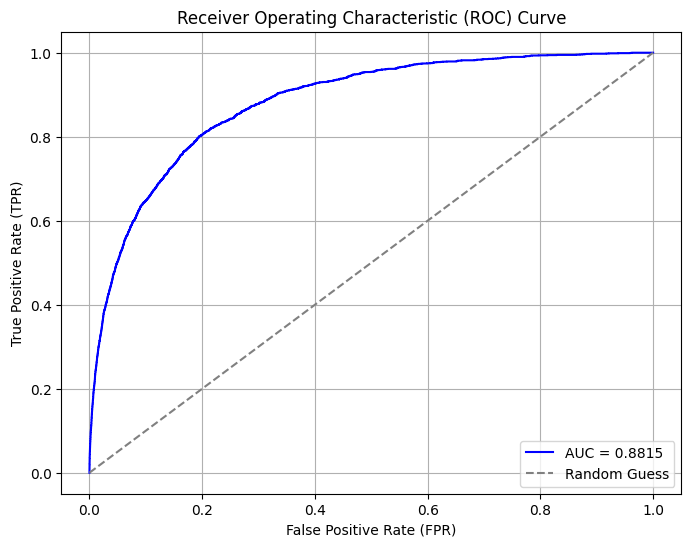

In [33]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {baseline_auc:.4f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

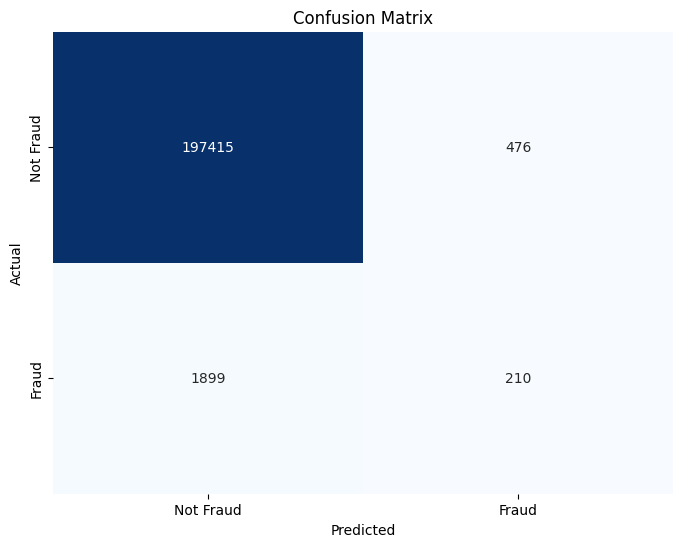

In [34]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

This is the baseline score before hyperparameter tuning. The only difference we made from the default model was using early stopping to set the number of estimators.

how is the true negative different from the one's that are not captured as fraud;
exmaine the true negatives and go back to the features to alter the figure
and let the model learn from new features 

# Tuning

## objective function

In [14]:
def objective(hyperparameters, iteration):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""
    
    # Number of estimators will be found using early stopping
    if 'n_estimators' in hyperparameters.keys():
        del hyperparameters['n_estimators']
    
     # Perform n_folds cross validation
    cv_results = xgb.cv(params=hyperparameters, dtrain = dtrain, num_boost_round = 10000, nfold = 5, 
                        early_stopping_rounds = 5, metrics = 'auc', seed = 42)
    
    # results to retun
    score = cv_results['test-auc-mean'].max()
    estimators = len(cv_results['test-auc-mean'])
    hyperparameters['n_estimators'] = estimators 
    
    return [score, hyperparameters, iteration]

## Grid search 

In [35]:
model = XGBClassifier()
model.n_estimators = optimal_num_rounds
param = model.get_params()
print(param)

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 185, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


uniform distribution vs. normal distribution in random search 

In [36]:
param_grid = {
    'eta': list(np.logspace(np.log10(0.001), np.log10(0.6), base = 10, num = 500)),
    'lambda': list(np.linspace(0.01, 0.2, num = 100)),
    'alpha': list(np.linspace(0.01, 0.2, 100)),
    'gamma': list(np.linspace(0, 20, 100)),
    'max_depth': list(range(3, 15, 1)),
    'subsample': list(np.linspace(0.5, 1, 5)),
    'colsample_bytree': list(np.linspace(0.5, 1, 5)),
    'objective': ['binary:logistic'],
    'eval_metric': ['auc'],
    'min_child_weight': list(np.linspace(0.8, 1.2, 5))
}

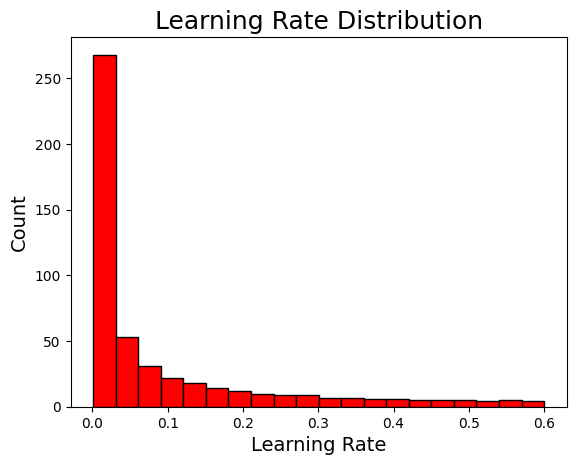

In [37]:
%matplotlib inline

# Learning rate histogram
plt.hist(param_grid['eta'], bins = 20, color = 'r', edgecolor = 'k');
plt.xlabel('Learning Rate', size = 14); plt.ylabel('Count', size = 14); plt.title('Learning Rate Distribution', size = 18);

Using a logarithmic uniform distribution allows us to create a domain where there are as many values from 0.005 to 0.05 as from 0.05 to 0.5.

This is useful for values that differ over several orders of magnitude such as the learning rate.
 
A logarithmic uniform distribution lets us sample more evenly from a domain that varies over several orders of magnitude.

 In the case of grid search, we input the domain and the algorithm selects the next value for each hyperparameter in an ordered sequence. The only requirement of grid search is that it tries every combination in a grid once (and only once). For random search, we input the domain and each time the algorithm gives us a random combination of hyperparameter values to try. 

Text(0, 0.5, 'Count')

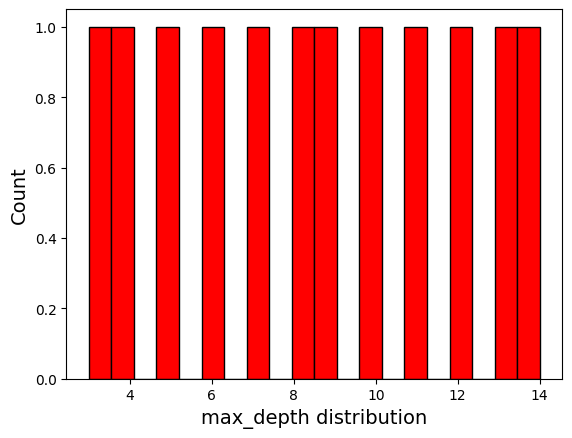

In [139]:
%matplotlib inline

# Learning rate histogram
plt.hist(param_grid['max_depth'], bins = 20, color = 'r', edgecolor = 'k');
plt.xlabel('max_depth distribution', size = 14); plt.ylabel('Count', size = 14)

In [146]:
com = 1
for x in param_grid.values():
    com *= len(x)
    print('There are {} combinations'.format(com))

There are 500 combinations
There are 25000 combinations
There are 1250000 combinations
There are 125000000 combinations
There are 1500000000 combinations
There are 7500000000 combinations
There are 37500000000 combinations
There are 562500000000 combinations
There are 1687500000000 combinations
There are 8437500000000 combinations


In [40]:
import itertools
MAX_EVALS = 10
random_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))

grid_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))

def grid_search(param_grid, max_evals = MAX_EVALS):
    """Grid search algorithm (with limit on max evals)"""
    
    # Dataframe to store results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))
    
    # https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists
    keys, values = zip(*param_grid.items())
    
    i = 0
    
    # Iterate through every possible combination of hyperparameters
    for v in itertools.product(*values):
        
        # Create a hyperparameter dictionary
        hyperparameters = dict(zip(keys, v))
        
        # Evalute the hyperparameters
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
        
        i += 1
        
        # Normally would not limit iterations
        if i > MAX_EVALS:
            break
       
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    
    return results    

In [41]:
grid_results = grid_search(param_grid)

print('The best validation score was {:.5f}'.format(grid_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(grid_results.loc[0, 'params'])

The best validation score was 0.84160

The best hyperparameters were:
{'alpha': np.float64(0.01),
 'colsample_bytree': np.float64(0.5),
 'eta': np.float64(0.001),
 'eval_metric': 'auc',
 'gamma': np.float64(0.0),
 'lambda': np.float64(0.01),
 'max_depth': 3,
 'min_child_weight': np.float64(1.0),
 'n_estimators': 13,
 'objective': 'binary:logistic',
 'subsample': np.float64(0.5)}


In [ ]:
grid_search_params = grid_results.loc[0, 'params']
model_grid_search = XGBClassifier(**grid_search_params, random_state=42)
model.fit(dtrain, train_labels)

In [ ]:
final_model_test = xgb.train(
    params=parameters,
    dtrain=dtrain,
    num_boost_round=100,
    early_stopping_rounds=5,
    evals=[(dtrain, 'training'), (dtest, 'testing')],
    maximize=True,
    verbose_eval=True
)

In [73]:
# Train the model with the updated parameters
model.set_params(**parameters)
model.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'auc',
 'feature_types': None,
 'gamma': 0.2,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 4,
 'max_leaves': None,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 27,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'eta': 0.4}

In [75]:
num_boost_round_test = 100
n_folds = 10
early_stopping_rounds = 5

cv_results_test = xgb.cv(
    params=parameters,
    dtrain=dtrain,
    num_boost_round=num_boost_round_test,
    nfold=n_folds,
    metrics='auc',
    early_stopping_rounds=early_stopping_rounds,
    seed=42,
    verbose_eval=True,
)

[0]	train-auc:0.79393+0.00214	test-auc:0.79302+0.00613
[1]	train-auc:0.80894+0.00597	test-auc:0.80656+0.00924
[2]	train-auc:0.82354+0.00293	test-auc:0.82076+0.00538
[3]	train-auc:0.82851+0.00316	test-auc:0.82471+0.00453
[4]	train-auc:0.83577+0.00163	test-auc:0.83254+0.00593
[5]	train-auc:0.83969+0.00132	test-auc:0.83681+0.00592
[6]	train-auc:0.84333+0.00133	test-auc:0.84124+0.00646
[7]	train-auc:0.85468+0.00171	test-auc:0.85125+0.00580
[8]	train-auc:0.86232+0.00162	test-auc:0.85767+0.00628
[9]	train-auc:0.86814+0.00140	test-auc:0.86287+0.00559
[10]	train-auc:0.87351+0.00113	test-auc:0.86868+0.00509
[11]	train-auc:0.87766+0.00098	test-auc:0.87233+0.00534
[12]	train-auc:0.88114+0.00076	test-auc:0.87532+0.00527
[13]	train-auc:0.88404+0.00073	test-auc:0.87801+0.00530
[14]	train-auc:0.88648+0.00068	test-auc:0.88017+0.00530
[15]	train-auc:0.88872+0.00052	test-auc:0.88205+0.00538
[16]	train-auc:0.89067+0.00052	test-auc:0.88356+0.00529
[17]	train-auc:0.89223+0.00046	test-auc:0.88476+0.00520
[1

In [76]:
optimal_num_rounds = len(cv_results_test)
print(f"Optimal number of boosting rounds: {optimal_num_rounds}")

best_auc = cv_results_test['test-auc-mean'].max()
print(f"Best CV AUC: {best_auc:.4f}")

Optimal number of boosting rounds: 48
Best CV AUC: 0.8932


In [85]:
final_model_test = xgb.train(
    params=parameters,
    dtrain=dtrain,
    num_boost_round=100,
    early_stopping_rounds=5,
    evals=[(dtrain, 'training'), (dtest, 'testing')],
    maximize=True,
    verbose_eval=True
)

[0]	training-auc:0.79313	testing-auc:0.79219
[1]	training-auc:0.81668	testing-auc:0.81307
[2]	training-auc:0.82261	testing-auc:0.81876
[3]	training-auc:0.82989	testing-auc:0.82600
[4]	training-auc:0.83795	testing-auc:0.83377
[5]	training-auc:0.84060	testing-auc:0.83654
[6]	training-auc:0.84397	testing-auc:0.84132
[7]	training-auc:0.85367	testing-auc:0.85071
[8]	training-auc:0.85922	testing-auc:0.85721
[9]	training-auc:0.86798	testing-auc:0.86507
[10]	training-auc:0.87313	testing-auc:0.87092
[11]	training-auc:0.87602	testing-auc:0.87354
[12]	training-auc:0.87903	testing-auc:0.87530
[13]	training-auc:0.88243	testing-auc:0.87778
[14]	training-auc:0.88549	testing-auc:0.88052
[15]	training-auc:0.88746	testing-auc:0.88175
[16]	training-auc:0.88963	testing-auc:0.88306
[17]	training-auc:0.89137	testing-auc:0.88465
[18]	training-auc:0.89240	testing-auc:0.88536
[19]	training-auc:0.89353	testing-auc:0.88592
[20]	training-auc:0.89523	testing-auc:0.88812
[21]	training-auc:0.89660	testing-auc:0.8891

In [91]:
final_model_test.attributes()

{'best_iteration': '62', 'best_score': '0.897458107790271'}

# tuning with random search

In [42]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [77]:
def fit_xgb_binary(xgb_train, xgb_test, iterations=1):
    """
    Train a binary classification model using XGBoost with randomized hyperparameter search.

    Parameters:
        xgb_train: XGBoost DMatrix for training
        xgb_test: XGBoost DMatrix for testing
        iterations: number of iterations for hyperparameter tuning

    Returns:
        Trained XGBoost model
    """
    best_auc = 0
    best_params = {}

    for _ in range(iterations):
        # Random hyperparameters for this iteration
        hparams = {
            'eta': np.random.uniform(0.01, 0.6),
            'lambda': np.random.uniform(0.01, 0.2),
            'alpha': np.random.uniform(0.01, 0.2),
            'gamma': np.random.uniform(0, 20),
            'max_depth': np.random.randint(3, 15),
            'subsample': np.random.uniform(0.5, 1),
            'colsample_bytree': np.random.uniform(0.5, 1),
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'min_child_weight': np.random.uniform(0.8, 1.2)
        }

        # Cross-validation
        xgb_cv = xgb.cv(
            params=hparams,
            dtrain=xgb_train,
            num_boost_round=52,
            nfold=10,
            early_stopping_rounds=2,
            metrics=['auc'],
            maximize=True,
            verbose_eval=2
        )

        # Get the best AUC score from CV
        best_iteration = xgb_cv['test-auc-mean'].idxmax()
        auc_score = xgb_cv['test-auc-mean'][best_iteration]

        # Update best params if the new score is better
        if auc_score > best_auc:
            best_auc = auc_score
            best_params = hparams

    # Train the final model with the best hyperparameters
    final_model = xgb.train(
        params=best_params,
        dtrain=xgb_train,
        num_boost_round=50,
        early_stopping_rounds=3,
        evals=[(xgb_train, 'training'), (xgb_test, 'testing')],
        maximize=True,
        verbose_eval=2
    )

    return final_model, best_params, best_auc

In [78]:
final_model, best_params, best_auc = fit_xgb_binary(dtrain, dtest, iterations=5)

[0]	train-auc:0.81353+0.00161	test-auc:0.81082+0.00688
[2]	train-auc:0.83389+0.00213	test-auc:0.83028+0.00883
[4]	train-auc:0.84039+0.00169	test-auc:0.83688+0.00866
[6]	train-auc:0.84534+0.00113	test-auc:0.84097+0.00772
[8]	train-auc:0.85181+0.00096	test-auc:0.84667+0.00784
[10]	train-auc:0.85839+0.00103	test-auc:0.85267+0.00711
[12]	train-auc:0.86142+0.00078	test-auc:0.85522+0.00727
[14]	train-auc:0.86390+0.00092	test-auc:0.85716+0.00699
[16]	train-auc:0.86953+0.00131	test-auc:0.86210+0.00642
[18]	train-auc:0.87539+0.00092	test-auc:0.86755+0.00700
[20]	train-auc:0.88100+0.00083	test-auc:0.87239+0.00637
[22]	train-auc:0.88554+0.00066	test-auc:0.87576+0.00659
[24]	train-auc:0.88942+0.00075	test-auc:0.87879+0.00667
[26]	train-auc:0.89222+0.00078	test-auc:0.88089+0.00612
[28]	train-auc:0.89501+0.00079	test-auc:0.88281+0.00606
[30]	train-auc:0.89740+0.00067	test-auc:0.88424+0.00622
[32]	train-auc:0.89951+0.00055	test-auc:0.88545+0.00634
[34]	train-auc:0.90149+0.00068	test-auc:0.88677+0.006

In [81]:
print(best_params, best_auc)

{'eta': 0.19229545808697532, 'lambda': 0.06770652472612759, 'alpha': 0.13161618937790642, 'gamma': 0.4932988918488146, 'max_depth': 5, 'subsample': 0.789267471165026, 'colsample_bytree': 0.8779666388531073, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'min_child_weight': 1.1583385157539368} 0.8918971766819503


In [93]:
final_model.attributes()

{'best_iteration': '49', 'best_score': '0.8944375408813966'}